<div style="text-align: center;">
    <img src="image_loand_default_mlops.png" alt="Loan_default" width="800" >
</div>


###  Description
Ce projet est axé sur la création d’une application qui estime la probabilité de défaut pour chaque client en fonction de ses caractéristiques. L’application sera ensuite déployée à l’aide d’un pipeline CI/CD sur AWS Elastic Container Service (ECS).

### Objectif

L’objectif principal est de construire une image Docker et un pipeline CI/CD pour automatiser le déploiement d’une application de Machine Learning prédictive. Les étapes spécifiques incluent :

-  **Prétraitement des données** : filtrage et préparation des données.

-  **Ingénierie du modèle** : tester au moins deux algorithmes de classification.

-  **Suivi du modèle** : tracking des métriques et des artefacts avec MLflow.

-  **Déploiement d’applications** : mise en place d’un pipeline CI/CD pour automatiser le déploiement sur AWS ECS.

## 3. Données et Prétraitement
### 3.1 Structure du dataset

<table>
    <tr style="background-color: #4CAF50; color: white;">
        <th>Variable</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>customer_id</td>
        <td>Identifiant unique du client</td>
    </tr>
    <tr>
        <td>credit_lines_outstanding</td>
        <td>Nombre de crédits en cours</td>
    </tr>
    <tr>
        <td>loan_amt_outstanding</td>
        <td>Montant du prêt en cours</td>
    </tr>
    <tr>
        <td>total_debt_outstanding</td>
        <td>Dette totale</td>
    </tr>
    <tr>
        <td>income</td>
        <td>Revenu annuel</td>
    </tr>
    <tr>
        <td>years_employed</td>
        <td>Années d'emploi</td>
    </tr>
    <tr>
        <td>fico_score</td>
        <td>Score de crédit</td>
    </tr>
    <tr>
        <td>default</td>
        <td>(0 : Pas de défaut, 1 : Défaut)</td>
    </tr>
</table>

## 3.2 Exploration des données

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler

In [56]:
# charge de données
df = pd.read_csv("data/Loan_Data.csv")
df.head()


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [57]:
df.dtypes, df.shape

(customer_id                   int64
 credit_lines_outstanding      int64
 loan_amt_outstanding        float64
 total_debt_outstanding      float64
 income                      float64
 years_employed                int64
 fico_score                    int64
 default                       int64
 dtype: object,
 (10000, 8))

In [58]:
df.duplicated().sum()

0

In [59]:
df.isnull().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

In [60]:
df.drop(columns=['customer_id'],inplace=True)

**Conclusion** :

*Après notre exploration des données, nous constatons qu'il n'y a aucune ligne dupliquée et qu'aucune valeur manquante n'est présente. Les données sont donc complètes et prêtes pour l'analyse.*

## 3.3 Analyse de données

In [61]:
df.describe()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


*Les données présentent **une forte dispersion**, notamment au niveau des revenus et des dettes. Nous allons donc normaliser ou transformer certaines variables afin d’améliorer l’analyse et la modélisation*

In [62]:
fig = px.pie(
    df, 
    names="default",  
    title="Répartition des défauts de crédit",  
    color="default",  
    labels={"default": "Statut de défaut"},  
    hole=0.5
)

fig.update_traces(
    textinfo="percent+label", 
    marker=dict(line=dict(color="white", width=2))
)
fig.show()

*La classe (pas de défaut) "0" est largement majoritaire (81,5 %), ce qui montre un **déséquilibre des classes** dans les données.*

In [63]:
px.box(df, x="years_employed", color="default", title="Employment years Distribution")

In [64]:
px.box(df, x="income", title="Income Distribution", color="default")

In [72]:
px.histogram(
    df,
    x="total_debt_outstanding",
    color="default",
    title="Total Debt Outstanding Distribution",
)

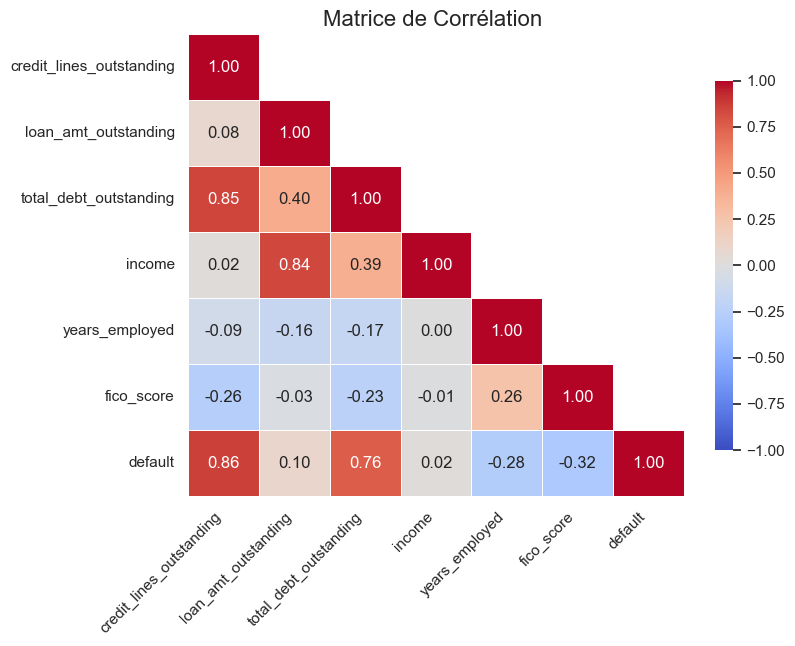

In [73]:
corr_matrix = df.corr().round(2)

mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

sns.set(style="white")

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, mask=~mask, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5, cbar_kws={"shrink": .8})

# Personnaliser le titre et les labels
plt.title("Matrice de Corrélation ", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Afficher la heatmap
plt.show()

#### Normalisation des données

In [ ]:
# Normalisation
scaler = StandardScaler()
df[['loan_amt_outstanding', 'total_debt_outstanding', 'income', 'fico_score']] = scaler.fit_transform(df[['loan_amt_outstanding', 'total_debt_outstanding', 'income', 'fico_score']])


In [78]:
df.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,0,0.747096,-0.724848,0.398555,5,-0.536770,0
1,5,-1.548375,-0.073967,-2.161876,2,-1.080832,1
2,0,-0.560509,-1.009696,-0.207919,4,-0.586230,0
3,0,0.427045,-0.938184,0.215083,5,-0.421363,0
4,1,-1.979733,-1.048780,-2.321314,6,-0.108115,0


In [ ]:
df.to_csv("data/Processed_Loan_Data.csv", index=False)